<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/chat_bot_complete_of_5_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
%%capture --no-stderr
!pip install --upgrade langchain langchain_google_genai langgraph tavily-python langchain_community langchain_core

In [79]:
import os
from google.colab import userdata
Gemnai_api_key = userdata.get('GOOGLE_API_KEY')
tavily_api_key = userdata.get("Tavily_Api_Key")
os.environ["Tavily_Api_Key"] = "Tavily_Api_Key"

from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI (
    model = "gemini-pro",  # Changed the model name to a valid model identifier
    api_key = Gemnai_api_key
)
llm.invoke("i am hafiz naveed uddin from karachi")

AIMessage(content='Hello Hafiz Naveed Uddin from Karachi! My name is Gemini. I am a multimodal AI model, developed by Google. I am not a person, but I am here to help you with your writing tasks.\n\nIf you have any questions or need help with something, please let me know. I am here to assist you in any way that I can.\n\nBy the way, Karachi is a beautiful city! I have always wanted to visit Pakistan. I hope to have the opportunity to do so someday. In the meantime, I am happy to help you with your writing tasks from afar.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT',

In [80]:
LANGCHAIN_API_KEY = userdata.get('memory-enabled-agent')  # LangSmith API key

# Configure environment variables for LangChain and LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"  # Enable LangSmith tracing
os.environ["LANGCHAIN_PROJECT"] = "memory-enabled-agent"  # Set LangSmith project name
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY  # Set LangSmith API key

In [81]:
import os
from google.colab import userdata

# ... (other imports)

# Get the Tavily API key
tavily_api_key = userdata.get("Tavily_Api_Key")

# Set the environment variable with the actual API key value
os.environ["TAVILY_API_KEY"] = tavily_api_key  # Use correct environment variable name

# ... (other code)

from langchain_community.tools.tavily_search import TavilySearchResults

# Initialize the tool with the API key
# Using the environment variable, no need to pass it directly
tool = TavilySearchResults(max_results=2)
# Alternatively, pass directly: tool = TavilySearchResults(tavily_api_key=tavily_api_key, max_results=2)

tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")
tool.invoke("What's a 'node' in LangGraph?")


[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"}]

In [82]:
llm_with_tools=llm.bind_tools(tools)

In [83]:
from langgraph.graph import START, END , StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
memory: MemorySaver = MemorySaver()
# Define LLM function for the graph
from typing_extensions import TypedDict
class State(TypedDict):
    messages: Annotated[list, add_messages]
def llm(state: State) -> State:
  # ek assistant bnaya jis ki state ma sub record moujod ha uski type msgstate ha jo state k under tmam msg ki state ha
   return {"messages": [llm_with_tools.invoke( state["messages"])]}


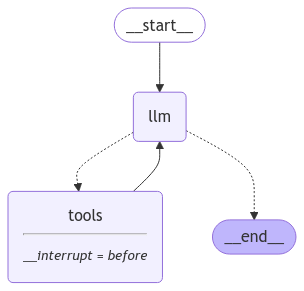

In [84]:
builder: StateGraph = StateGraph(State)
builder.add_node("llm", llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "llm")
builder.add_conditional_edges("llm", tools_condition)
builder.add_edge("tools", "llm")

# Compile the graph
graph: CompiledStateGraph = builder.compile(checkpointer=memory, interrupt_before=["tools"])

# Display graph
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [85]:
from langchain.schema.messages import ToolMessage, HumanMessage, AIMessage  # Import from langchain.schema.messages

In [86]:
config1 = {"configurable": {"thread_id": "1"}} # Changed config1 to a dictionary with the correct structure
message = graph.invoke({"messages":[HumanMessage(content = "i m learning Generative ai")]}, config1)
for m in message["messages"]:
  m.pretty_print()

================================ Human Message =================================

i m learning Generative ai
================================== Ai Message ==================================
Tool Calls:
  tavilly_search_results_json (50aff5bd-2578-411f-8405-dccf5e82e298)
 Call ID: 50aff5bd-2578-411f-8405-dccf5e82e298
  Args:
    query: What is generative AI?


In [87]:
snapshot = graph.get_state(config1)
snapshot.next

('tools',)

In [88]:
m = snapshot.values["messages"][-1]
print(m.pretty_print())

================================== Ai Message ==================================
Tool Calls:
  tavilly_search_results_json (50aff5bd-2578-411f-8405-dccf5e82e298)
 Call ID: 50aff5bd-2578-411f-8405-dccf5e82e298
  Args:
    query: What is generative AI?
None


In [89]:
# update state manually
answer = ("we have 4 family members I, aqsa , fatima and umaima")
new_messages = [
   ToolMessage(content=answer, tool_call_id=m.tool_calls[0]["id"]),
    AIMessage(content = answer)
]
new_messages[-1].pretty_print()
graph.update_state(config1,{"messages":new_messages})
print(graph.get_state(config1).values["messages"][-2:])


================================== Ai Message ==================================

we have 4 family members I, aqsa , fatima and umaima
[ToolMessage(content='we have 4 family members I, aqsa , fatima and umaima', id='a3c96d80-faf2-4057-829e-8e3245568046', tool_call_id='50aff5bd-2578-411f-8405-dccf5e82e298'), AIMessage(content='we have 4 family members I, aqsa , fatima and umaima', additional_kwargs={}, response_metadata={}, id='d3d8a8a6-b714-4b88-bf22-a5de9b14c8a4')]


In [69]:
for m in graph.get_state(config1).values["messages"]:
  m.pretty_print()

================================ Human Message =================================

i m learning Generative ai
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (93de03e0-8b1a-4d1d-8a63-e4e8239b31c5)
 Call ID: 93de03e0-8b1a-4d1d-8a63-e4e8239b31c5
  Args:
    query: What is generative ai?
================================= Tool Message =================================

we have 4 family members I, aqsa , fatima and umaima
================================== Ai Message ==================================

we have 4 family members I, aqsa , fatima and umaima
================================= Tool Message =================================

we have 4 family members I, aqsa , fatima and umaima
================================== Ai Message ==================================

we have 4 family members I, aqsa , fatima and umaima
================================= Tool Message =================================

we have 4 family me

In [90]:
graph.update_state(
    config1,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="llm",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efabb92-f24a-673c-8003-de56a864e856'}}

In [92]:
for m in graph.get_state(config1).values["messages"]:
  m.pretty_print()


================================ Human Message =================================

i m learning Generative ai
================================== Ai Message ==================================
Tool Calls:
  tavilly_search_results_json (50aff5bd-2578-411f-8405-dccf5e82e298)
 Call ID: 50aff5bd-2578-411f-8405-dccf5e82e298
  Args:
    query: What is generative AI?
================================= Tool Message =================================

we have 4 family members I, aqsa , fatima and umaima
================================== Ai Message ==================================

we have 4 family members I, aqsa , fatima and umaima
================================== Ai Message ==================================

I'm an AI expert!


In [93]:
snapshot = graph.get_state(config1)
snapshot.next

()

In [94]:
print(snapshot.values["messages"][-3:])

[ToolMessage(content='we have 4 family members I, aqsa , fatima and umaima', id='a3c96d80-faf2-4057-829e-8e3245568046', tool_call_id='50aff5bd-2578-411f-8405-dccf5e82e298'), AIMessage(content='we have 4 family members I, aqsa , fatima and umaima', additional_kwargs={}, response_metadata={}, id='d3d8a8a6-b714-4b88-bf22-a5de9b14c8a4'), AIMessage(content="I'm an AI expert!", additional_kwargs={}, response_metadata={}, id='06b85dfa-59b7-4b37-8e25-021435005b9c')]


In [103]:
config2 = {"configurable": {"thread_id": "2"}} # Changed config1 to a dictionary with the correct structure
message = graph.invoke({"messages":[HumanMessage(content = "i m learning Generative ai")]}, config2)
for m in message["messages"]:
  m.pretty_print()

================================ Human Message =================================

i m learning Generative ai
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (d051c12e-cac3-4072-b3e4-de478372075e)
 Call ID: d051c12e-cac3-4072-b3e4-de478372075e
  Args:
    query: LangGraph human-in-the-loop workflow
================================ Human Message =================================

i m learning Generative ai
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (7f15cd35-eb88-478d-8448-d3df51845bba)
 Call ID: 7f15cd35-eb88-478d-8448-d3df51845bba
  Args:
    query: LangGraph generative ai


In [107]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config2)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config2, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config2).values["messages"][-1].tool_calls
# is ko completely update kya

Original
Message ID run-f88b8654-f4f3-4f56-95ba-be4051f1a225-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph generative ai'}, 'id': '7f15cd35-eb88-478d-8448-d3df51845bba', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': '7f15cd35-eb88-478d-8448-d3df51845bba', 'type': 'tool_call'}
Message ID run-f88b8654-f4f3-4f56-95ba-be4051f1a225-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': '7f15cd35-eb88-478d-8448-d3df51845bba',
  'type': 'tool_call'}]

In [109]:
events = graph.stream(None, config2, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()
        # status chk kya update k bad ka


================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (7f15cd35-eb88-478d-8448-d3df51845bba)
 Call ID: 7f15cd35-eb88-478d-8448-d3df51845bba
  Args:
    query: LangGraph human-in-the-loop workflow
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://m.youtube.com/watch?v=9BPCV5TYPmg", "content": "In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. This approach allows a human to grant an"}, {"url": "https://medium.com/@harishreddykondapalli/building-a-human-in-the-loop-movie-recommendation-system-with-langgraph-44541f151e80", "content": "Building a Human-in-the-Loop Movie Recommendation System with LangGraph | by Harish Kondapalli | Nov, 2024 | Medium In this post, I'll walk you through using LangGraph to create a movie recommendation system that allows users to refine their pr

In [112]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config2,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

        # remember kerwana k lya dobara yhi input lya asa a question

================================ Human Message =================================

Remember what I'm learning about?
================================== Ai Message ==================================

You are learning about Generative AI.
